In [5]:
# To use the latest version of the sliderule client, run this cell.
# It will install the sliderule Python client into your current conda environment.
# You will then need to restart your kernel to have the changes take effect.
# %pip install --quiet "sliderule>=4.6"

In [122]:
from sliderule import sliderule, icesat2
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon, LineString, Point
from pyproj import Transformer
import xarray as xr
import rasterio

import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [123]:
sliderule.init("slideruleearth.io");

Client (version (4, 5, 3)) is out of date with the server (version (4, 6, 2))


In [124]:
region = sliderule.toregion("data/Glacier_polygons/Petermann.geojson");

In [125]:
# (4) Specify the processing parameters
parms = {
    "poly": region["poly"],
    "srt": icesat2.SRT_LAND,
    # "len": 20.0,
    # "res": 100.0,
    "t0": datetime.date(2021, 1, 1).strftime('%Y-%m-%dT%H:%M:%SZ'),
    "t1": datetime.date(2023, 1, 1).strftime('%Y-%m-%dT%H:%M:%SZ'),
    "atl06_fields": ["dem/geoid_h"]
}

In [126]:
# (5) Make the processing request
gdf = icesat2.atl06sp(parms)
gdf = gdf.dropna(subset=['h_li']) # remove points outside of the ATL06 land ice mask


In [127]:
# Polygon coords

region_lon = [e["lon"] for e in region["poly"]]
region_lat = [e["lat"] for e in region["poly"]]

In [128]:
# %matplotlib widget

# f, ax = plt.subplots()
# ax.set_title("ATL06-SR Points")
# ax.set_aspect('equal')
# gdf.plot(ax=ax, column='h_li', cmap='inferno', s=0.1, vmin = 100, vmax = 500)
# ax.plot(region_lon, region_lat, linewidth=1, color='g')
# # ax.set_aspect('equal')
# plt.show()

In [129]:
## Reprojection using pyproj
def reproj(X, Y, source_epsg, target_epsg):
    lon = []
    lat = []
    transformer = Transformer.from_crs(source_epsg, target_epsg, always_xy=True)

    if len(X) == len(Y):
        for i in range(len(X)):
            lon1, lat1 = transformer.transform(X[i], Y[i])
            lon.append(lon1)
            lat.append(lat1)
    else:
        raise ValueError("X and Y must be of the same length.")
    return lon, lat

In [130]:
coords = np.stack(gdf.geometry.apply(lambda x: np.array(x.coords).ravel()))
gdf["x_3413"], gdf["y_3413"] = reproj(coords[:, 0], coords[:, 1], "epsg:4326", "epsg:3413")
    

In [131]:
## Read in bedmachine data

Bed_ele_f = "data/BedMachine/BedMachineGreenland-v5.nc"
Bed_ele = xr.open_dataset(Bed_ele_f)
Bed_ele

<xarray.Dataset> Size: 4GB
Dimensions:    (x: 10218, y: 18346)
Coordinates:
  * x          (x) int32 41kB -652925 -652775 -652625 ... 879325 879475 879625
  * y          (y) int32 73kB -632675 -632825 -632975 ... -3384275 -3384425
Data variables:
    mapping    |S1 1B ...
    mask       (y, x) int8 187MB ...
    surface    (y, x) float32 750MB ...
    thickness  (y, x) float32 750MB ...
    bed        (y, x) float32 750MB ...
    errbed     (y, x) float32 750MB ...
    source     (y, x) int8 187MB ...
    dataid     (y, x) int8 187MB ...
    geoid      (y, x) int16 375MB ...
Attributes: (12/16)
    Conventions:                 CF-1.7
    Title:                       BedMachine Greenland
    Author:                      Mathieu Morlighem
    version:                     28-Jul-2022 (v5.5)
    nx:                          10218.0
    ny:                          18346.0
    ...                          ...
    xmin:                        -652925
    ymax:                        -632675
    spacing:                     150
    no_data:                     -9999.0
    license:                     No restrictions on access or use
    Data_citation:               Morlighem M. et al., (2017), BedMachine v3: ...

In [132]:
# Add projection info to the "bed" variable (probably don't need this step using rioxarray)
bed_projected = Bed_ele.bed.rio.write_crs(3413, inplace=True).rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=True).rio.write_coordinate_system(inplace=True).to_dataset()

## Reproject the region of interest to polar stereographic north, same as what BedMachine is using
# region_poly = region["gdf"].to_crs(3413) 
# len(region_poly["geometry"][0].exterior.coords.xy[0]) # Seems like the SlideRule.toregion simplyfy the geometry from in "gdf" to "poly" due to the "cellsize" parameter

# Use the "poly" from SlideRule.toregion
x_poly = [list(i.values())[0] for i in region["poly"]]
y_poly = [list(i.values())[1] for i in region["poly"]]
gdf_poly = gpd.GeoDataFrame(index=[0], crs='epsg:4326', geometry=[Polygon(zip(x_poly, y_poly))])
region_poly = gdf_poly.to_crs(3413) 


# Subset/crop BedMachine using the region of interest
bed_subset = bed_projected.rio.clip(region_poly.geometry.values, region_poly.crs, all_touched = True)
bed_subset

<xarray.Dataset> Size: 91kB
Dimensions:      (x: 164, y: 137)
Coordinates:
  * x            (x) int32 656B -270725 -270575 -270425 ... -246425 -246275
  * y            (y) int32 548B -985175 -985325 -985475 ... -1005425 -1005575
    spatial_ref  int64 8B 0
    mapping      int64 8B 0
Data variables:
    bed          (y, x) float32 90kB nan nan nan nan nan ... nan nan nan nan nan

In [133]:
## Subset BedMachine and get bed elevation at the location of ICESat-2 data

res_BM = 150 # spatial resolution of BedMachine: 150 m

# reference bedmachine (BM) coordinates: lower left corner of the BM map
x_ref = bed_subset["x"].values[0]
y_ref = bed_subset["y"].values[0]

# relative position of ICESat-2 data to BM, potential negative values due to the mismatch between 
x_IS2 = np.round((gdf["x_3413"].values - x_ref)/res_BM).astype("int")
y_IS2 = np.round((y_ref - gdf["y_3413"].values)/res_BM).astype("int")
# The negative values could be due to projection transformation, when reproject, the location in between polygon points won't be identical

# mask for the negative values
mask_positive = (x_IS2>0)&(y_IS2>0)

# get bed elevation at location of ICESat-2 data point
bed_IS2 = bed_subset["bed"].values[y_IS2[mask_positive], x_IS2[mask_positive]]
bed_IS2_all = np.full([len(gdf)], np.nan)
bed_IS2_all[mask_positive] = bed_IS2

# add bed elevation to ICESat-2 GeoDataFrame
gdf["bed_ele"] = bed_IS2_all

In [139]:

# Only keep rows where the bedrock is beneath sea-level
gdf_bsl = gdf[gdf["bed_ele"]<0]

# Floation height
fh = np.abs(gdf_bsl["bed_ele"]*108/917)
gdf_bsl["floatation_height"] = fh




/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


**Equation used to calculate floatation height**

Based on the Archimedes' principle:

```{math}
:label: my_label
\rho_{ice} * H_{ice} = \rho_{water} * H_{water}\\
\rho_{ice} * (H_{water} + H_{floatation}) = \rho_{water} * H_{water}
```

Assuming sea water density of 1025 $kg/m^{3}$ and ice density of 917 $kg/m^{3}$, we have:

```{math}
:label: my_label
H_{floatation} \~= 108 / 917 * H_{water}
```

In [1]:
# Grounded mask
thre = 0 # meters

# if surface height is higher than the floatation height by thre, define it as grounded
mask_grounded = gdf_bsl["h_li"] - gdf_bsl["dem/geoid_h"] - gdf_bsl["floatation_height"] > thre 
gdf_bsl["mask_grounded"] = mask_grounded

gdf_bsl

NameError: name 'gdf_bsl' is not defined

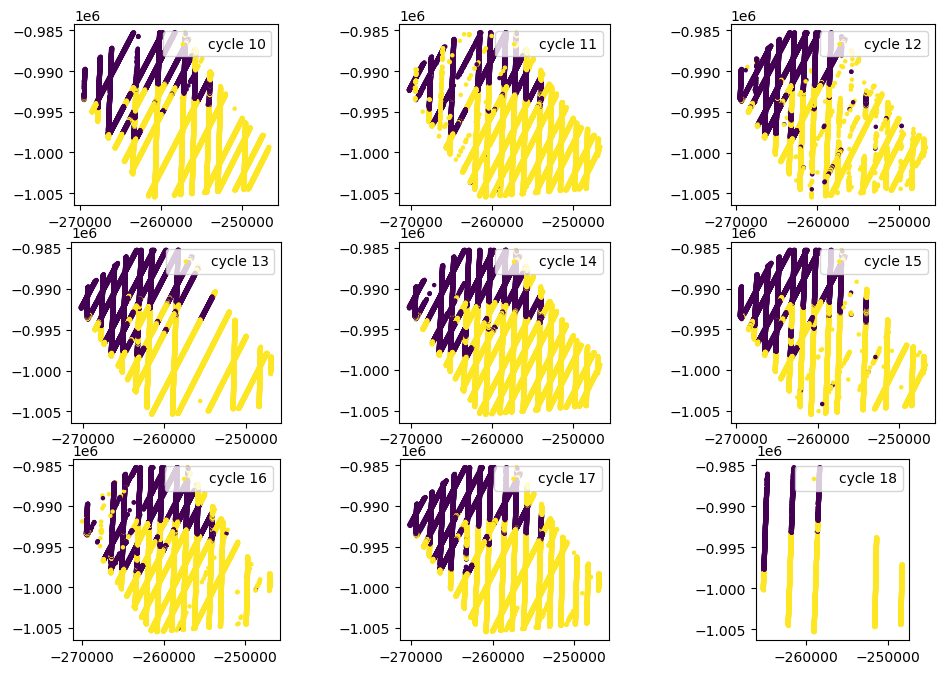

In [138]:
%matplotlib inline

## grounded vs. floating in each cycle from ATL06

cycles = np.unique(gdf_bsl["cycle"].values)

fig, ax = plt.subplots(int(len(cycles)/3), 3, figsize = (12, 8))
axs = ax.ravel()

for i, cycle in enumerate(cycles):
    gdf_cycle = gdf_bsl[gdf_bsl["cycle"] == cycle]
    # date_cycle = gdf_cycle.index[0].date().strftime('%Y-%m-%dT')
    im = axs[i].scatter(gdf_cycle["x_3413"], gdf_cycle["y_3413"], c = gdf_cycle["mask_grounded"].values, 
                     marker="o", s = 5, label = "cycle "+str(cycle))
    
      
    axs[i].set_aspect('equal')
    axs[i].legend(loc = "best")

plt.show()


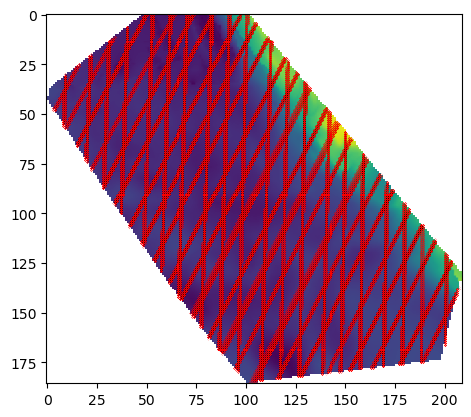

In [135]:
fig, ax = plt.subplots()
ax.imshow(bed_subset["bed"].values)
ax.scatter(x_IC2, y_IC2, c = "red", s = 0.01)
ax.set_aspect('equal')
plt.show()